In [11]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '../..')

import random
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint
from control import lqr

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import plot_importance

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from envs.env import WoundEnv, SimpleEnv
from cfgs.config import GetParameters

In [16]:
args = GetParameters()
args.alg_rl = 'ppo'
args.spt = False
# args.model_dir = '../../../../res_wound_rl/res_healnet/models/models_{}/'.format(args.alg_rl)
# args.model_dir = '../../../../res_wound_rl/res_healnet/res/models/models_{}/'.format(args.alg_rl)
args.model_dir = '../../../../res_wound_rl/res/models_08_10/models_{}/'.format(args.alg_rl)
args.data_dir = '../../../../res_wound_rl/res/data/data_{}/'.format(args.alg_rl)
args.figs_dir = '../res/figs/figs_{}/'.format(args.alg_rl)

In [17]:
env4 = SimpleEnv(args)
env5 = WoundEnv(args)

In [18]:
state_buf_ode4 = np.zeros((0, 4))
state_buf_ode5 = np.zeros((0, 500))

In [19]:
def dynamic5(state_buf, env):
    state = env.reset()
    for t in range(env.t_nums - 1):
        state_next, reward, done, info = env.step(0)
        state_buf = np.vstack((state_buf, state))
        state = state_next
    state_buf = np.vstack((state_buf, state))
    return state_buf
def dynamic4(state_buf, env):
    state = env.reset()
    for t in range(env.t_nums - 1):
        state_next, reward, done, info = env.step(np.array([0.5, 0.3, 0.1]))
        state_buf = np.vstack((state_buf, state))
        state = state_next
    state_buf = np.vstack((state_buf, state))
    return state_buf

In [20]:
state_buf_ode4 = dynamic4(state_buf_ode4, env4)
state_buf_ode5 = dynamic5(state_buf_ode5, env5)

In [21]:
nose_amp = 0.05
ns = 10
X = np.vstack([np.clip(
                state_buf_ode4 + np.random.uniform(-nose_amp, nose_amp, (state_buf_ode4.shape)), 0, 1) 
              for _ in range(ns)])
y = np.vstack([state_buf_ode5 for _ in range(ns)])

In [22]:
regressor = MultiOutputRegressor(GradientBoostingRegressor(random_state=0, n_estimators=100, max_depth=7), n_jobs=5)
regressor.fit(X, y)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=7,
                                                         random_state=0),
                     n_jobs=5)

In [23]:
X_test = X[:601, :]
state_buf_ode5_predict = np.clip(regressor.predict(X_test), 0, 10)
state_buf_ode5_predict = state_buf_ode5_predict.reshape(601, 5, 100) 
state_buf_ode5_predict[:, 0, 0] = np.clip(state_buf_ode5_predict[:, 0, 0], 0, 1)
state_buf_ode5_predict[:, 1, 0] = np.clip(state_buf_ode5_predict[:, 1, 0], 0, 1)
state_buf_ode5_predict[:, 2, 0] = np.clip(state_buf_ode5_predict[:, 2, 0], 0, 1)
state_buf_ode5_predict[:, 3, 0] = np.clip(state_buf_ode5_predict[:, 3, 0], 0, 5)
state_buf_ode5_predict[:, 4, 0] = np.clip(state_buf_ode5_predict[:, 4, 0], 0, 1)

NameError: name 'state_buf_ode5_rs' is not defined

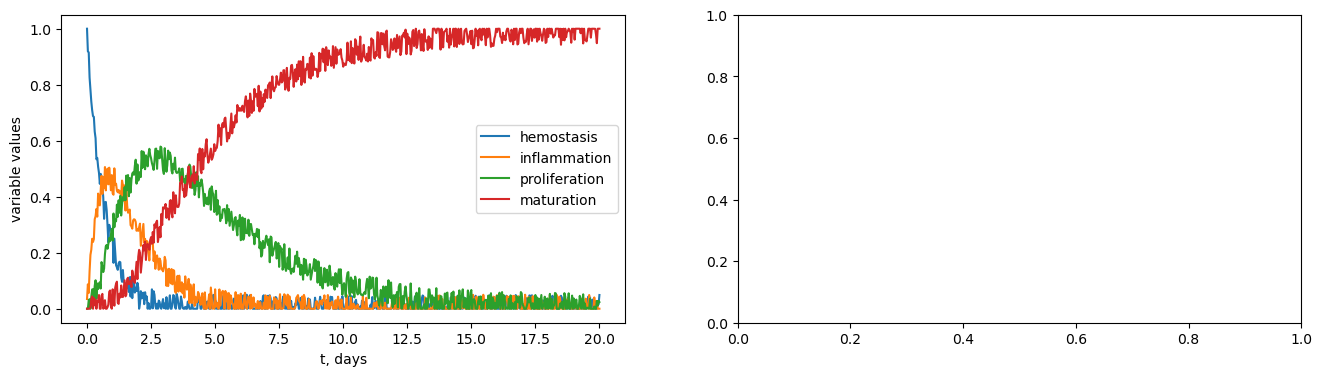

In [24]:
t_range = np.linspace(0, env4.t_days, env4.t_nums) / 3
fig = plt.figure(figsize=(16, 4), num=2)
ax = fig.add_subplot(121)
ax.plot(t_range, X_test[:, 0], label='hemostasis')
ax.plot(t_range, X_test[:, 1], label='inflammation')
ax.plot(t_range, X_test[:, 2], label='proliferation')
ax.plot(t_range, X_test[:, 3], label='maturation')
ax.set_xlabel('t, days')
ax.set_ylabel('variable values')

ax.legend()

lines = []

ax = fig.add_subplot(122)
state_buf_ode5_predict_rs = state_buf_ode5_predict.reshape(601, 5, 100) 
ax.plot(t_range, state_buf_ode5_rs[:, 0, 0], linestyle='-', c='r', label='debris')
ax.plot(t_range, state_buf_ode5_rs[:, 1, 0], linestyle='-', c='g', label='macropage M1')
ax.plot(t_range, state_buf_ode5_rs[:, 2, 0], linestyle='-', c='b', label='macropage M2')
ax.plot(t_range, state_buf_ode5_rs[:, 3, 0] / 5, linestyle='-', c='c', label='temporary tissue')
lines += ax.plot(t_range, state_buf_ode5_rs[:, 4, 0], linestyle='-', c='y', label='new tissue')

ax.plot(t_range, state_buf_ode5_predict_rs[:, 0, 0], linestyle='--', c='r')
ax.plot(t_range, state_buf_ode5_predict_rs[:, 1, 0], linestyle='--', c='g')
ax.plot(t_range, state_buf_ode5_predict_rs[:, 2, 0], linestyle='--', c='b')
ax.plot(t_range, state_buf_ode5_predict_rs[:, 3, 0] / 5, linestyle='--', c='c')
lines += ax.plot(t_range, state_buf_ode5_predict_rs[:, 4, 0], linestyle='--', c='y')

ax.legend(bbox_to_anchor=(0.6, 0.8), loc='center right', borderaxespad=0)
from matplotlib.legend import Legend
leg = Legend(ax, lines, ['true trajectory', 'predicted trajectory'],
             bbox_to_anchor=(0.35, 0.89), 
             loc='center right', borderaxespad=0, frameon=True)
ax.add_artist(leg)

ax.set_xlabel('t, days')
ax.set_ylabel('variable values')

plt.tight_layout()
plt.savefig(args.figs_dir + 'map_45ode.pdf', format='pdf')
plt.savefig(args.figs_dir + 'map_45ode.svg', format='svg')